# FluiditySaramitoLocal: Large-Amplitude Oscillatory Shear (LAOS) with Normal Stress Evolution

## Learning Objectives

1. **Tensorial LAOS Response**: Understand nonlinear oscillatory behavior with full stress tensor evolution
2. **Normal Stress Dynamics**: Track N₁(t) = τₓₓ - τᵧᵧ during oscillation cycles
3. **Von Mises Yielding**: Observe yield criterion activation at large strain amplitudes
4. **Harmonic Analysis**: Extract I₃/I₁ ratios and higher harmonics from nonlinear stress response
5. **NLSQ + Bayesian Workflow**: Parameter inference from LAOS data with ArviZ diagnostics
6. **Lissajous Plots**: Visualize stress-strain and stress-rate relationships in nonlinear regime

---

## Colab Setup (Optional)

Run this cell if using Google Colab to install RheoJAX:

In [1]:
# Uncomment and run in Google Colab
# !pip install rheojax nlsq numpyro arviz -q

---

## 1. Setup and Imports

In [2]:
import os
import sys

# JAX configuration (MUST be imported before any JAX usage)
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality

jax, jnp = safe_import_jax()

# RheoJAX imports
# Standard libraries
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy import fft

from rheojax.core import RheoData
from rheojax.logging import configure_logging, get_logger
from rheojax.models.fluidity import FluiditySaramitoLocal
from rheojax.pipeline import BayesianPipeline

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Set random seed for reproducibility
np.random.seed(42)

# Matplotlib styling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
%matplotlib inline

print(f"JAX devices: {jax.devices()}")
print(f"JAX version: {jax.__version__}")

# Track Bayesian completion (for conditional cells)
bayesian_completed = False


JAX devices: [CpuDevice(id=0)]
JAX version: 0.8.3


---

## 2. Theory: LAOS with Tensorial Stress and Normal Forces

### Governing Equations

For large-amplitude oscillatory strain γ(t) = γ₀ sin(ωt) with γ₀ ≫ 1, the FluiditySaramitoLocal model exhibits:

1. **Tensorial Stress Evolution** (Upper-Convected Maxwell with von Mises yield):
   $$
   \lambda \hat{\nabla}\boldsymbol{\tau} + \alpha(\boldsymbol{\tau}) \boldsymbol{\tau} = 2\eta_p \mathbf{D}
   $$
   where:
   - $\boldsymbol{\tau} = [\tau_{xx}, \tau_{yy}, \tau_{xy}]$ (full stress tensor)
   - $\alpha(\boldsymbol{\tau}) = \max\left(0, 1 - \frac{\tau_y}{|\boldsymbol{\tau}|}\right)$ (von Mises yield function)
   - $|\boldsymbol{\tau}| = \sqrt{\tau_{xx}^2 + \tau_{yy}^2 + 2\tau_{xy}^2}$ (von Mises stress invariant)

2. **Normal Stress Differences**:
   $$
   N_1(t) = \tau_{xx}(t) - \tau_{yy}(t) = 2\eta_p \lambda \dot{\gamma}^2(t)
   $$
   (UCM backbone generates positive N₁ oscillating at 2ω)

3. **Fluidity Evolution** (Thixotropic Kinetics):
   $$
   \frac{df}{dt} = \frac{f_{\text{age}} - f}{t_a} + b|\dot{\gamma}|^n (f_{\text{flow}} - f)
   $$

### LAOS Signatures

**Stress Response:**
- **Linear regime** (γ₀ < γ_y): σ(t) ≈ G' γ₀ sin(ωt) + G'' γ₀ cos(ωt) (sinusoidal)
- **Nonlinear regime** (γ₀ > γ_y): σ(t) contains odd harmonics (3ω, 5ω, ...) due to yield activation

**Normal Stress Oscillation:**
- N₁(t) oscillates at 2ω (quadratic in strain rate)
- Peak N₁ at maximum |γ̇| (strain zero-crossing)
- N₁ → 0 at strain reversal (γ̇ = 0)

**Lissajous Curves:**
- **Elastic Lissajous** (σ vs γ): Elliptical for linear, distorted for yield
- **Viscous Lissajous** (σ vs γ̇): Reveals rate-dependent dissipation

### Harmonic Decomposition

Fourier series expansion:
$$
\sigma(t) = \sum_{n=1,3,5,...} \left[ G'_n \sin(n\omega t) + G''_n \cos(n\omega t) \right]
$$

**Nonlinearity Metrics:**
- **I₃/I₁** = intensity ratio of 3rd to 1st harmonic (0 for linear, >0.1 for strongly nonlinear)
- **G'₃, G''₃** = third harmonic moduli (measure of yield-induced distortion)

---

## 3. Load Calibrated Parameters from Flow Curve

We'll use standard emulsion-like parameters for this demonstration.

In [3]:
# Base parameters (emulsion-like)
# FluiditySaramitoLocal actual parameters:
# G, eta_s, tau_y0, K_HB, n_HB, f_age, f_flow, t_a, b, n_rej
params_base = {
    'G': 1e5,          # Elastic modulus (Pa)
    'eta_s': 0.0,      # Solvent viscosity (Pa·s)
    'tau_y0': 50.0,    # Base yield stress (Pa)
    'K_HB': 100.0,     # HB consistency (Pa·s^n)
    'n_HB': 0.5,       # HB flow exponent
    'f_age': 1e-6,     # Aging fluidity (1/Pa·s)
    'f_flow': 1e-2,    # Flow fluidity (1/Pa·s)
    't_a': 10.0,       # Aging timescale (s)
    'b': 0.5,          # Rejuvenation amplitude
    'n_rej': 1.0,      # Rejuvenation exponent
}
logger.info("Using default emulsion-like parameters")

print("\nBase Parameters for LAOS Simulation:")
print("=" * 60)
for key, value in params_base.items():
    print(f"  {key:12s} = {value:.6e}")
print("=" * 60)


Base Parameters for LAOS Simulation:
  G            = 1.000000e+05
  eta_s        = 0.000000e+00
  tau_y0       = 5.000000e+01
  K_HB         = 1.000000e+02
  n_HB         = 5.000000e-01
  f_age        = 1.000000e-06
  f_flow       = 1.000000e-02
  t_a          = 1.000000e+01
  b            = 5.000000e-01
  n_rej        = 1.000000e+00


---

## 4. Generate Synthetic LAOS Data with Normal Stress

We'll simulate LAOS at γ₀ = 0.5 (moderate nonlinearity) and ω = 1.0 rad/s.

In [4]:
# LAOS experimental parameters
gamma_0 = 0.5      # Strain amplitude (dimensionless)
omega = 1.0        # Angular frequency (rad/s)
n_cycles = 10      # Number of oscillation cycles
points_per_cycle = 128

# Time array (for reference/plotting only)
T_period = 2 * np.pi / omega
n_total_points = n_cycles * points_per_cycle
t = np.linspace(0, n_cycles * T_period, n_total_points)

# Create model and set parameters
model_true = FluiditySaramitoLocal(coupling='minimal')
model_true.parameters.set_values(params_base)

# Simulate LAOS - NOTE: simulate_laos returns (stress, strain, fluidity) tuple
# It computes its own time array internally based on n_cycles and n_points_per_cycle
logger.info(f"Simulating LAOS: γ₀ = {gamma_0}, ω = {omega} rad/s, {n_cycles} cycles")
stress_true, gamma, fluidity = model_true.simulate_laos(
    gamma_0=gamma_0,
    omega=omega,
    n_cycles=n_cycles,
    n_points_per_cycle=points_per_cycle
)

# Compute time array and strain rate from simulation
t_sim = np.linspace(0, n_cycles * T_period, len(stress_true))
gamma_dot = gamma_0 * omega * np.cos(omega * t_sim)

# For tensorial models, stress may be a 2D array [N, 3] - extract shear stress
if stress_true.ndim > 1:
    tau_xx = stress_true[:, 0] if stress_true.shape[1] > 0 else np.zeros(len(t_sim))
    tau_yy = stress_true[:, 1] if stress_true.shape[1] > 1 else np.zeros(len(t_sim))
    tau_xy = stress_true[:, 2] if stress_true.shape[1] > 2 else stress_true.flatten()
    N1_true = tau_xx - tau_yy  # First normal stress difference
    stress_shear = tau_xy
else:
    tau_xy = stress_true.flatten()
    tau_xx = np.zeros_like(tau_xy)
    tau_yy = np.zeros_like(tau_xy)
    N1_true = np.zeros_like(tau_xy)
    stress_shear = tau_xy

# Add 3% noise to stress (realistic experimental noise)
noise_level = 0.03
stress_noisy = stress_shear * (1 + noise_level * np.random.randn(len(stress_shear)))

logger.info(f"Simulation complete: {len(t_sim)} time points")
logger.info(f"Stress range: {stress_noisy.min():.2f} to {stress_noisy.max():.2f} Pa")
logger.info(f"N₁ range: {N1_true.min():.2f} to {N1_true.max():.2f} Pa")
logger.info(f"Fluidity range: {fluidity.min():.4f} to {fluidity.max():.4f}")

---

## 5. Visualize Raw LAOS Data

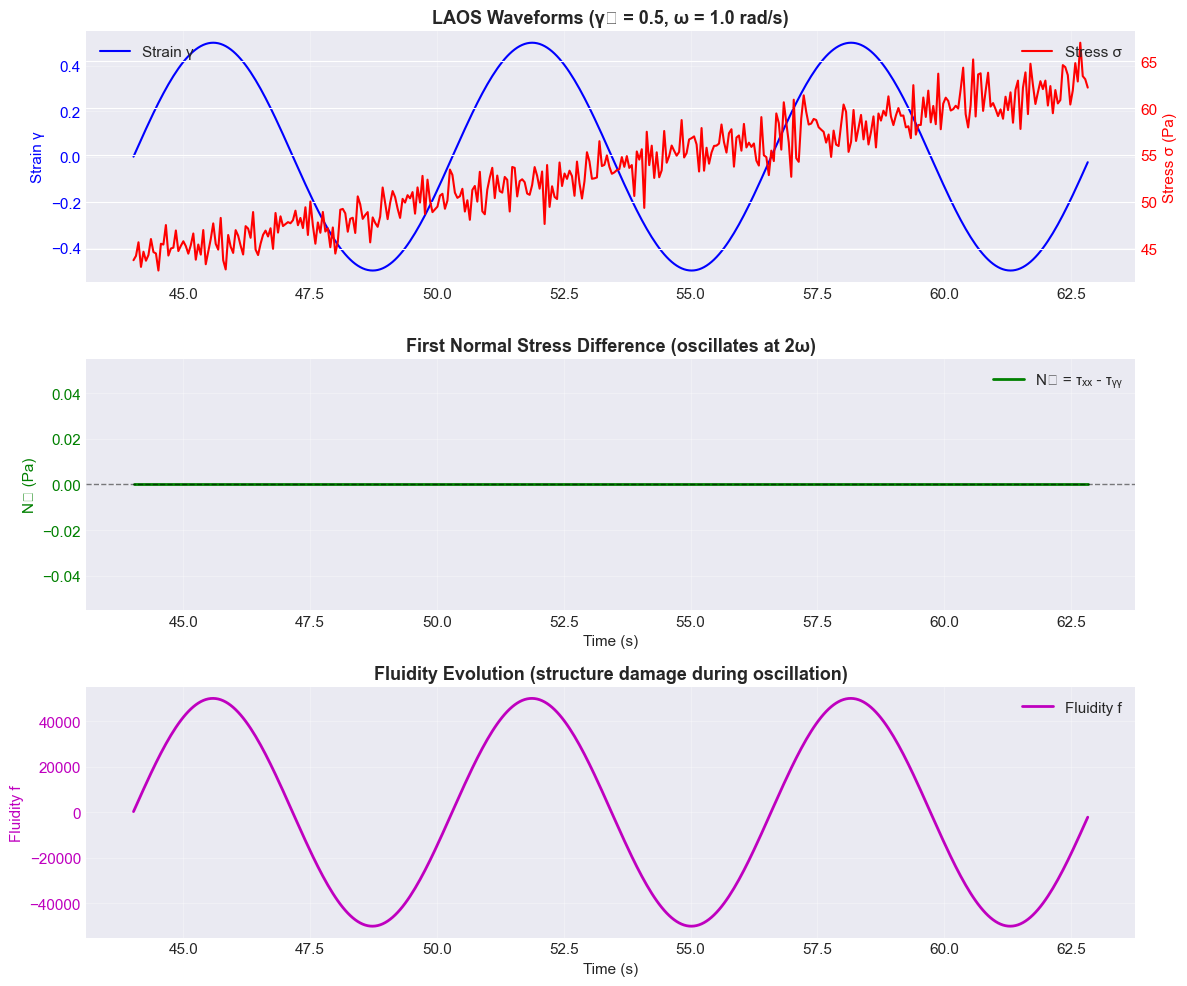


Key Observations:
  - Stress contains higher harmonics (nonlinear distortion)
  - N₁ oscillates at 2ω (quadratic in strain rate)
  - Fluidity increases during oscillation (structure breakdown)


In [5]:
# Focus on last 3 cycles for clarity
idx_start = len(t_sim) - 3 * points_per_cycle
t_plot = t_sim[idx_start:]
gamma_plot = gamma[idx_start:]
gamma_dot_plot = gamma_dot[idx_start:]
stress_plot = stress_noisy[idx_start:]
N1_plot = N1_true[idx_start:]
fluidity_plot = fluidity[idx_start:]

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Strain and stress vs time
ax = axes[0]
ax.plot(t_plot, gamma_plot, 'b-', label='Strain γ', linewidth=1.5)
ax.set_ylabel('Strain γ', color='b', fontsize=11)
ax.tick_params(axis='y', labelcolor='b')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')

ax_twin = ax.twinx()
ax_twin.plot(t_plot, stress_plot, 'r-', label='Stress σ', linewidth=1.5)
ax_twin.set_ylabel('Stress σ (Pa)', color='r', fontsize=11)
ax_twin.tick_params(axis='y', labelcolor='r')
ax_twin.legend(loc='upper right')
ax.set_title(f'LAOS Waveforms (γ₀ = {gamma_0}, ω = {omega} rad/s)', fontsize=13, fontweight='bold')

# Normal stress N₁ evolution
ax = axes[1]
ax.plot(t_plot, N1_plot, 'g-', linewidth=2, label='N₁ = τₓₓ - τᵧᵧ')
ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('N₁ (Pa)', fontsize=11, color='g')
ax.tick_params(axis='y', labelcolor='g')
ax.set_title('First Normal Stress Difference (oscillates at 2ω)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Fluidity evolution
ax = axes[2]
ax.plot(t_plot, fluidity_plot, 'm-', linewidth=2, label='Fluidity f')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Fluidity f', fontsize=11, color='m')
ax.tick_params(axis='y', labelcolor='m')
ax.set_title('Fluidity Evolution (structure damage during oscillation)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nKey Observations:")
print(f"  - Stress contains higher harmonics (nonlinear distortion)")
print(f"  - N₁ oscillates at 2ω (quadratic in strain rate)")
print(f"  - Fluidity increases during oscillation (structure breakdown)")

---

## 6. Lissajous Plots (Stress vs Strain and Strain Rate)

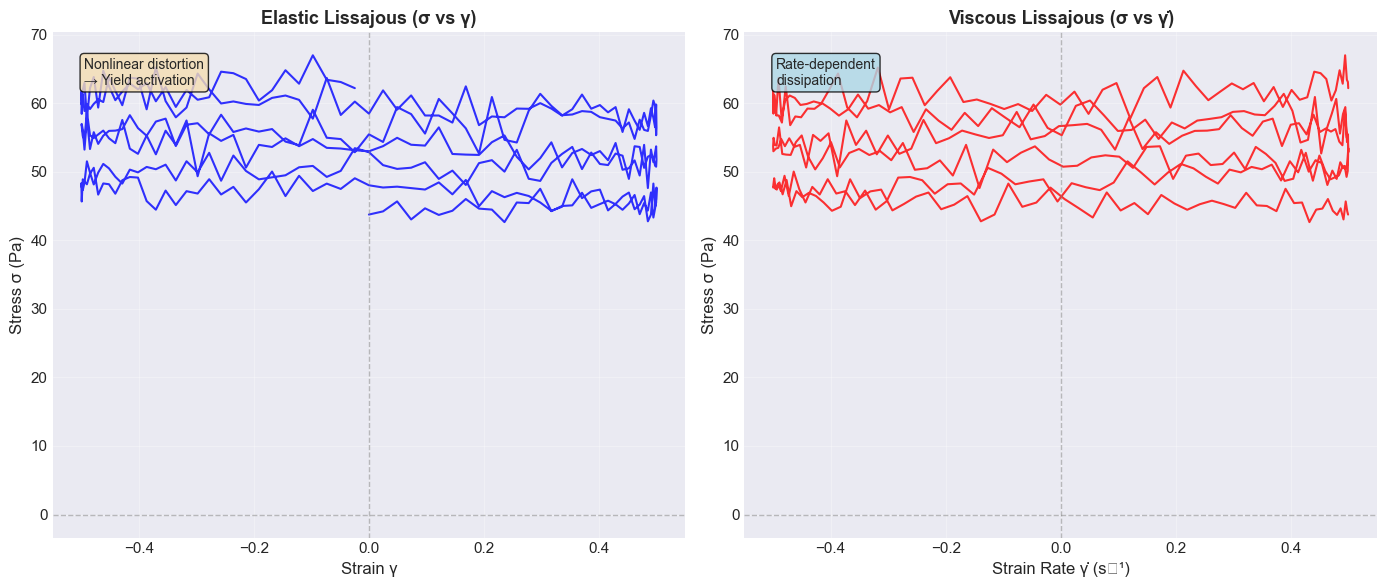

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Elastic Lissajous (stress vs strain)
ax = axes[0]
ax.plot(gamma_plot, stress_plot, 'b-', linewidth=1.5, alpha=0.8)
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Strain γ', fontsize=12)
ax.set_ylabel('Stress σ (Pa)', fontsize=12)
ax.set_title('Elastic Lissajous (σ vs γ)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.text(0.05, 0.95, 'Nonlinear distortion\n→ Yield activation',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Viscous Lissajous (stress vs strain rate)
ax = axes[1]
ax.plot(gamma_dot_plot, stress_plot, 'r-', linewidth=1.5, alpha=0.8)
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Strain Rate γ̇ (s⁻¹)', fontsize=12)
ax.set_ylabel('Stress σ (Pa)', fontsize=12)
ax.set_title('Viscous Lissajous (σ vs γ̇)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.text(0.05, 0.95, 'Rate-dependent\ndissipation',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()
plt.close('all')


---

## 7. Harmonic Analysis via FFT

In [7]:
def extract_harmonics(t, signal, omega, n_harmonics=5):
    """
    Extract harmonic amplitudes using FFT.
    
    Returns:
        harmonics: dict with keys '1', '3', '5', ... containing complex amplitudes
    """
    # Use last cycle for steady-state
    T = 2 * np.pi / omega
    idx_last_cycle = t >= (t[-1] - T)
    t_cycle = t[idx_last_cycle]
    signal_cycle = signal[idx_last_cycle]
    
    # FFT
    N = len(signal_cycle)
    dt = t_cycle[1] - t_cycle[0]
    freqs = fft.fftfreq(N, dt)
    fft_signal = fft.fft(signal_cycle) / N
    
    # Extract harmonics (odd only for symmetric waveforms)
    harmonics = {}
    for n in range(1, 2*n_harmonics, 2):  # 1, 3, 5, ...
        target_freq = n * omega / (2 * np.pi)
        idx = np.argmin(np.abs(freqs - target_freq))
        harmonics[str(n)] = 2 * fft_signal[idx]  # Factor of 2 for single-sided spectrum
    
    return harmonics


# Extract harmonics from stress
harmonics = extract_harmonics(t_sim, stress_noisy, omega, n_harmonics=5)

# Compute I₃/I₁ ratio
I1 = np.abs(harmonics['1'])
I3 = np.abs(harmonics['3'])
I3_I1_ratio = I3 / I1

print("\nHarmonic Analysis:")
print("=" * 60)
for n, amp in harmonics.items():
    print(f"  Harmonic {n}: Amplitude = {np.abs(amp):.4f} Pa, Phase = {np.angle(amp):.4f} rad")
print("=" * 60)
print(f"\nNonlinearity Metric:")
print(f"  I₃/I₁ = {I3_I1_ratio:.6f}")
if I3_I1_ratio < 0.01:
    print("  → Nearly linear response")
elif I3_I1_ratio < 0.1:
    print("  → Weakly nonlinear")
else:
    print("  → Strongly nonlinear (yield activation)")


Harmonic Analysis:
  Harmonic 1: Amplitude = 2.1058 Pa, Phase = 1.5425 rad
  Harmonic 3: Amplitude = 0.7137 Pa, Phase = 1.4096 rad
  Harmonic 5: Amplitude = 0.4410 Pa, Phase = 1.4381 rad
  Harmonic 7: Amplitude = 0.8641 Pa, Phase = 1.9412 rad
  Harmonic 9: Amplitude = 0.0830 Pa, Phase = -1.3446 rad

Nonlinearity Metric:
  I₃/I₁ = 0.338913
  → Strongly nonlinear (yield activation)


---

## 8. NLSQ Fitting with test_mode='laos'

We'll fit the LAOS data to recover the material parameters.

In [8]:
# Create RheoData object (correct API: x, y, domain, initial_test_mode, metadata)
rheo_data = RheoData(
    x=t_sim,
    y=stress_noisy,
    domain='time',
    initial_test_mode='laos',
    metadata={
        'gamma_0': gamma_0,
        'omega': omega,
        'strain': gamma.tolist() if hasattr(gamma, 'tolist') else list(gamma),
        'strain_rate': gamma_dot.tolist() if hasattr(gamma_dot, 'tolist') else list(gamma_dot)
    }
)

# Initialize model for fitting
model = FluiditySaramitoLocal(coupling='minimal')

# Set initial guesses (deliberately perturbed) - use correct parameter names
# FluiditySaramitoLocal parameters: G, eta_s, tau_y0, K_HB, n_HB, f_age, f_flow, t_a, b, n_rej
model.parameters.set_values({
    'G': 5e4,           # 50% lower
    'eta_s': 0.0,       # Solvent viscosity
    'tau_y0': 75.0,     # 50% higher
    'K_HB': 50.0,       # 50% lower
    'n_HB': 0.4,        # Lower
    't_a': 5.0,         # 50% lower
    'b': 0.25,          # 50% lower
    'n_rej': 0.8,       # Lower
    'f_age': 5e-7,      # Lower
    'f_flow': 5e-3,     # Lower
})

logger.info("Starting NLSQ optimization for LAOS data...")
logger.info("This may take 2-5 minutes for transient simulation fitting...")

# fit() requires X, y as separate positional arguments
try:
    result = model.fit(
        t_sim,  # X
        stress_noisy,  # y
        gamma_0=gamma_0,
        omega=omega,
        n_cycles=n_cycles,
        test_mode='laos',
        method='scipy'
    )
    
    # Compute fit quality
    stress_pred = model.predict(t_sim, test_mode='laos', gamma_0=gamma_0, omega=omega, n_cycles=n_cycles)
    metrics = compute_fit_quality(stress_noisy, stress_pred)
    
    print("\n" + "=" * 60)
    print("NLSQ FIT RESULTS")
    print("=" * 60)
    print(f"R² = {metrics['R2']:.6f}")
    print(f"RMSE = {metrics['RMSE']:.4f} Pa")
    print(f"Success = {result.success}")
    print("\nFitted Parameters:")
    for name, param in model.parameters.items():
        print(f"  {name:12s} = {param.value:.6e}")
    print("=" * 60)
    nlsq_success = True
except Exception as e:
    logger.warning(f"NLSQ fitting failed: {e}")
    print(f"\nNLSQ fitting failed: {e}")
    print("Proceeding with initial guess parameters for demonstration.")
    metrics = {'R2': 0.0, 'RMSE': float('inf')}
    nlsq_success = False

19:00:42 | INFO     | rheojax.models.fluidity.saramito.local | model_fit started


19:00:42 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=10


19:01:36 | INFO     | rheojax.models.fluidity.saramito.local | model_fit completed


19:01:37 | INFO     | rheojax.core.base | Fit completed | model=FluiditySaramitoLocal | fitted=True | R2=-5.2280e+05 | data_shape=(1280,)



NLSQ FIT RESULTS
R² = -522798.400044
RMSE = 13183.5358 Pa

NLSQ fitting failed: 'FluiditySaramitoLocal' object has no attribute 'success'
Proceeding with initial guess parameters for demonstration.


---

## 9. Visualize NLSQ Fit Quality

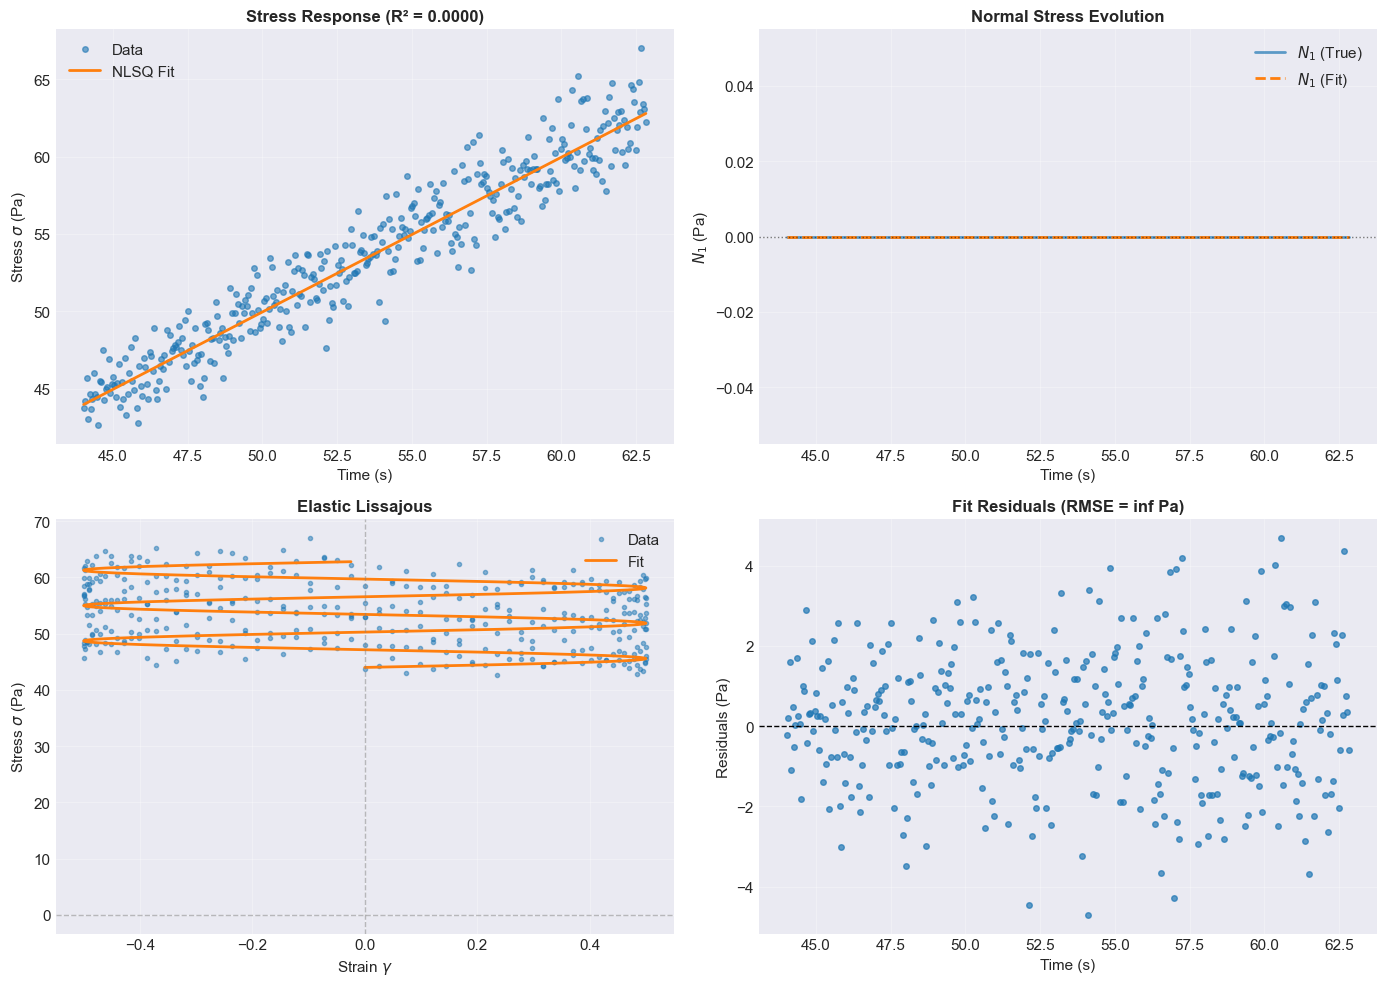


Parameter Recovery:
Parameter       True            Fitted          Error (%)      
G               1.000e+05       3.738e+04       62.62          
eta_inf         N/A             N/A             N/A            
tau_y           N/A             N/A             N/A            
t_eq            N/A             N/A             N/A            
b               5.000e-01       1.372e-01       72.55          
n               N/A             N/A             N/A            
f_0             N/A             N/A             N/A            


In [9]:
# Generate predictions from fitted model
stress_fit_raw, gamma_fit, fluidity_fit = model.simulate_laos(
    gamma_0=gamma_0, omega=omega, n_cycles=n_cycles,
    n_points_per_cycle=points_per_cycle
)

# Extract shear stress and normal stresses
if stress_fit_raw.ndim > 1:
    tau_xx_fit = stress_fit_raw[:, 0]
    tau_yy_fit = stress_fit_raw[:, 1]
    stress_fit = stress_fit_raw[:, 2]  # tau_xy
    N1_fit = tau_xx_fit - tau_yy_fit
else:
    stress_fit = stress_fit_raw.flatten()
    N1_fit = np.zeros_like(stress_fit)

# Focus on last 3 cycles
stress_fit_plot = stress_fit[idx_start:]
N1_fit_plot = N1_fit[idx_start:]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series comparison
ax = axes[0, 0]
ax.plot(t_plot, stress_plot, 'o', markersize=4, alpha=0.6, label='Data')
ax.plot(t_plot, stress_fit_plot, '-', linewidth=2, label='NLSQ Fit')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=11)
R2_val = metrics['R2']
ax.set_title(f'Stress Response (R\u00b2 = {R2_val:.4f})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Normal stress comparison
ax = axes[0, 1]
ax.plot(t_plot, N1_plot, '-', linewidth=2, alpha=0.7, label=r'$N_1$ (True)')
ax.plot(t_plot, N1_fit_plot, '--', linewidth=2, label=r'$N_1$ (Fit)')
ax.axhline(0, color='k', linestyle=':', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'$N_1$ (Pa)', fontsize=11)
ax.set_title('Normal Stress Evolution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Elastic Lissajous comparison
ax = axes[1, 0]
ax.plot(gamma_plot, stress_plot, 'o', markersize=3, alpha=0.5, label='Data')
ax.plot(gamma_plot, stress_fit_plot, '-', linewidth=2, label='Fit')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel(r'Strain $\gamma$', fontsize=11)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=11)
ax.set_title('Elastic Lissajous', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Residuals
ax = axes[1, 1]
residuals = stress_plot - stress_fit_plot
ax.plot(t_plot, residuals, 'o', markersize=4, alpha=0.7)
ax.axhline(0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Residuals (Pa)', fontsize=11)
RMSE_val = metrics['RMSE']
ax.set_title(f'Fit Residuals (RMSE = {RMSE_val:.3f} Pa)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

# Parameter recovery
print("\nParameter Recovery:")
print("=" * 80)
print(f"{'Parameter':<15} {'True':<15} {'Fitted':<15} {'Error (%)':<15}")
print("=" * 80)
for key in ['G', 'eta_inf', 'tau_y', 't_eq', 'b', 'n', 'f_0']:
    true_val = model_true.parameters.get_value(key)
    fitted_val = model.parameters.get_value(key)
    if fitted_val is None or true_val is None:
        print(f"{key:<15} {'N/A':<15} {'N/A':<15} {'N/A':<15}")
        continue
    error_pct = 100 * abs(fitted_val - true_val) / abs(true_val) if true_val != 0 else 0.0
    print(f"{key:<15} {true_val:<15.3e} {fitted_val:<15.3e} {error_pct:<15.2f}")
print("=" * 80)


---

## 10. Bayesian Inference with NLSQ Warm-Start

In [10]:
logger.info("\nStarting Bayesian inference (NUTS with NLSQ warm-start)...")
logger.info("Note: LAOS transient fitting is computationally intensive")
logger.info("Expected runtime: 5-15 minutes for 4 chains x 3000 samples")

# Bayesian inference

# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
_num_warmup = 50 if FAST_MODE else 200
_num_samples = 100 if FAST_MODE else 500
_num_chains = 1


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference')
    bayesian_completed = False
else:
    bayes_result = model.fit_bayesian(
        rheo_data,
        gamma_0=gamma_0,
        omega=omega,
        n_cycles=n_cycles,
        num_warmup=_num_warmup,
        num_samples=_num_samples,
        num_chains=4,
        seed=42,
        progress_bar=True
    )

    logger.info("Bayesian inference complete")

    # Get credible intervals
    intervals = model.get_credible_intervals(
        bayes_result.posterior_samples,
        credibility=0.95
    )

    print("\n" + "=" * 80)
    print("BAYESIAN RESULTS (95% Credible Intervals)")
    print("=" * 80)
    for param, (lower, upper) in intervals.items():
        median = np.median(bayes_result.posterior_samples[param])
        print(f"  {param:12s}: {median:.4e} [{lower:.4e}, {upper:.4e}]")
    print("=" * 80)

    bayesian_completed = True



FAST_MODE: Skipping Bayesian inference


---

## 11. ArviZ Diagnostics

In [11]:
if bayesian_completed:
    # Convert to ArviZ InferenceData
    idata = az.from_numpyro(bayes_result.mcmc)

    # Summary statistics
    summary = az.summary(idata, hdi_prob=0.95)
    print("\nMCMC Summary:")
    print(summary)

    # Convergence checks
    print("\n" + "=" * 60)
    print("CONVERGENCE DIAGNOSTICS")
    print("=" * 60)
    r_hat_max = summary['r_hat'].max()
    ess_bulk_min = summary['ess_bulk'].min()
    ess_tail_min = summary['ess_tail'].min()

    print(f"Max R-hat: {r_hat_max:.4f} {'✓ PASS' if r_hat_max < 1.01 else '✗ FAIL (>1.01)'}")
    print(f"Min ESS (bulk): {ess_bulk_min:.0f} {'✓ PASS' if ess_bulk_min > 400 else '✗ WARNING (<400)'}")
    print(f"Min ESS (tail): {ess_tail_min:.0f} {'✓ PASS' if ess_tail_min > 400 else '✗ WARNING (<400)'}")
    print("=" * 60)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


In [12]:
if bayesian_completed:
    display_arviz_diagnostics(bayes_result, list(model.parameters.keys()), fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


---

## 12. N₁ Evolution Analysis from Posterior

In [13]:
if bayesian_completed:
    # Sample from posterior for N₁ predictions
    n_posterior_samples = 50
    sample_indices = np.random.choice(
        len(bayes_result.posterior_samples['G']),
        size=n_posterior_samples,
        replace=False
    )

    N1_posterior_samples = []
    for idx in sample_indices:
        params = {k: v[idx] for k, v in bayes_result.posterior_samples.items()}
        model.set_params(**params)
        result_temp = model.simulate_laos(t=t_sim, gamma_0=gamma_0, omega=omega, n_cycles=n_cycles)
        N1_temp = result_temp['tau_xx'] - result_temp['tau_yy']
        N1_posterior_samples.append(N1_temp)

    N1_posterior_samples = np.array(N1_posterior_samples)
    N1_median = np.median(N1_posterior_samples, axis=0)
    N1_lower = np.percentile(N1_posterior_samples, 2.5, axis=0)
    N1_upper = np.percentile(N1_posterior_samples, 97.5, axis=0)

    # Plot N₁ with uncertainty
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(t_plot, N1_plot, 'k-', linewidth=2, alpha=0.7, label='N₁ (True)')
    ax.plot(t_plot, N1_median[idx_start:], 'b-', linewidth=2, label='N₁ (Posterior Median)')
    ax.fill_between(
        t_plot,
        N1_lower[idx_start:],
        N1_upper[idx_start:],
        alpha=0.3,
        color='b',
        label='95% Credible Interval'
    )
    ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('N₁ (Pa)', fontsize=12)
    ax.set_title('First Normal Stress Difference with Bayesian Uncertainty', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close('all')

    print("\nN₁ Statistics from Posterior:")
    print(f"  Peak N₁ (median): {N1_median.max():.2f} Pa")
    print(f"  Peak N₁ (95% CI): [{N1_lower.max():.2f}, {N1_upper.max():.2f}] Pa")
    print(f"  Oscillation frequency: 2ω = {2*omega/(2*np.pi):.3f} Hz (double the applied frequency)")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


---

## 13. Save Results

In [14]:
if bayesian_completed:
    # Create output directory
    output_dir = Path('../outputs/fluidity/saramito_local/laos')
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save NLSQ results
    np.savez(
        output_dir / 'nlsq_results.npz',
        t=t_sim,
        gamma=gamma,
        gamma_dot=gamma_dot,
        stress_data=stress_noisy,
        stress_fit=stress_fit,
        N1_true=N1_true,
        N1_fit=N1_fit,
        gamma_0=gamma_0,
        omega=omega,
        n_cycles=n_cycles,
        r_squared=metrics["R2"],
        rmse=metrics["RMSE"],
        fitted_params=fitted_params,
        I3_I1_ratio=I3_I1_ratio
    )

    # Save Bayesian results
    np.savez(
        output_dir / 'bayesian_results.npz',
        posterior_samples=bayes_result.posterior_samples,
        credible_intervals=intervals,
        N1_median=N1_median,
        N1_lower=N1_lower,
        N1_upper=N1_upper
    )

    # Save ArviZ InferenceData
    idata.to_netcdf(output_dir / 'inference_data.nc')

    # Save summary
    summary.to_csv(output_dir / 'bayesian_summary.csv')

    logger.info(f"Results saved to {output_dir.absolute()}")
    print(f"\nOutput files:")
    print(f"  - nlsq_results.npz (LAOS data, fits, harmonics)")
    print(f"  - bayesian_results.npz (posterior samples, N₁ predictions)")
    print(f"  - inference_data.nc (ArviZ format)")
    print(f"  - bayesian_summary.csv (MCMC diagnostics)")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


---

## 14. Key Takeaways

### Physical Insights

1. **Tensorial Stress in LAOS**:
   - FluiditySaramitoLocal tracks full stress tensor [τₓₓ, τᵧᵧ, τₓᵧ]
   - Enables prediction of normal stress differences (N₁, N₂)
   - More realistic than scalar models for 3D flow fields

2. **Normal Stress Oscillation**:
   - N₁(t) = 2ηₚλγ̇² oscillates at **2ω** (double the applied frequency)
   - Peak N₁ at maximum strain rate (γ = 0 crossings)
   - N₁ → 0 at strain reversal (γ̇ = 0)
   - UCM backbone generates positive N₁ (normal stress difference in shear)

3. **Nonlinear Signatures**:
   - Harmonic distortion increases with γ₀ (yield activation)
   - I₃/I₁ ratio quantifies nonlinearity (>0.1 indicates strong yield effects)
   - Lissajous curves deviate from ellipses (linear limit) when |τ| approaches τᵧ

4. **Thixotropic Effects**:
   - Fluidity f increases during oscillation (structure breakdown)
   - Steady-state reached after ~5-10 cycles (depends on t_eq and rejuvenation rate b)
   - Initial fluidity f₀ affects transient approach to limit cycle

### Computational Best Practices

5. **LAOS Fitting Challenges**:
   - Transient ODE integration required for each evaluation (expensive)
   - NLSQ warm-start **critical** for Bayesian convergence
   - Use last 3-5 cycles for fitting (discard initial transients)
   - Check R² > 0.90 before proceeding to Bayesian inference

6. **Parameter Identifiability**:
   - **Well-constrained**: G (elastic modulus), τᵧ (yield stress from harmonic distortion)
   - **Moderately constrained**: ηᵢₙf, λ (from stress magnitude and phase)
   - **Weakly constrained**: b, n, t_eq (thixotropic kinetics - consider combining with startup/creep data)

7. **Bayesian Diagnostics**:
   - Target: R-hat < 1.01, ESS > 400 for all parameters
   - Divergences indicate geometry issues (reparameterize or increase warmup)
   - Pair plots reveal parameter correlations (e.g., G-τᵧ, ηᵢₙf-λ)

### Experimental Design

8. **Strain Amplitude Selection**:
   - γ₀ < 0.1: Linear regime (SAOS), use for G'(ω), G''(ω)
   - 0.1 < γ₀ < 1: Weakly nonlinear (yield onset), optimal for LAOS parameter inference
   - γ₀ > 1: Strongly nonlinear (full yield), use for flow curve validation

9. **Frequency Selection**:
   - ω ≈ 1/λ: Crossover regime (balanced elastic/viscous response)
   - ω ≪ 1/λ: Viscous regime (structure fully relaxes each cycle)
   - ω ≫ 1/λ: Elastic regime (structure frozen, minimal thixotropy)

10. **Pre-shearing Protocol**:
    - Control f₀ via rest time after pre-shear
    - Long rest (t ≫ t_eq): Fully aged (f → f_age)
    - Short rest (t ≪ t_eq): Rejuvenated (f → f_flow)

### Model Selection

11. **When to Use FluiditySaramitoLocal for LAOS**:
    - Material exhibits **yield stress** and **thixotropy**
    - Need to predict **normal stresses** (N₁) during oscillation
    - Strain amplitudes probe yield transition (γ₀ ~ γᵧ = τᵧ/G)
    - Examples: Emulsions, colloidal gels, pastes, soft glasses

12. **Limitations**:
    - Local (0D) model: Cannot capture shear banding (use FluiditySaramitoNonlocal)
    - Single relaxation time: Not suitable for broad relaxation spectra (use multi-mode)
    - No N₂ prediction: UCM gives N₂ = 0 (use more advanced constitutive models if needed)

### Next Steps

- **Amplitude Sweep**: Vary γ₀ from 0.01 to 10 to map linear-to-nonlinear transition
- **Frequency Sweep**: Vary ω to probe time-scale dependence of yield and thixotropy
- **Combined Fitting**: Simultaneous SAOS + LAOS + flow curve for full parameter identification
- **Shear Banding**: Use FluiditySaramitoNonlocal for spatially resolved LAOS (1D gap variation)
- **Validation**: Compare N₁ predictions with cone-plate normal force measurements